### Automatic Differentation using PyTorch

In [1]:
from enum import Enum
import torch
from torch.distributions import Normal
import numpy as np
from tqdm import tqdm
from scipy.stats import norm

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline


torch.autograd.set_detect_anomaly(True)

#### Black Scholes

In [4]:
class OptionType(Enum):
    EuropeanCall = 1,
    EuropeanPut = 2

norm_cdf = Normal(0, 1).cdf
norm_pdf = lambda x: torch.exp(Normal(0, 1).log_prob(x))

In [5]:
def black_scholes(option_type: OptionType, K, S, T, sigma, r) -> float:
    d_1 = (1 / (sigma * torch.sqrt(T))) * (torch.log(S / K) + (r + (torch.square(sigma) / 2)) * T)
    d_2 = d_1 - sigma * torch.sqrt(T)

    if option_type == OptionType.EuropeanCall:
        call = norm_cdf(d_1) * S -norm_cdf(d_2) * K * torch.exp(-r * T)
        return call
    elif option_type == OptionType.EuropeanPut:
        put = norm_cdf(-d_2) * K * torch.exp(-r * T) - norm_cdf(-d_1) * S
        return put
    else:
        raise ValueError("Invalid Option time.")

#### Example Call with Greeks

In [6]:
K = torch.tensor(100.0, requires_grad=True)
S = torch.tensor(100.0, requires_grad=True)
T = torch.tensor(1.0, requires_grad=True)
sigma = torch.tensor(0.05, requires_grad=True)
r = torch.tensor(0.01, requires_grad=True)

price = black_scholes(OptionType.EuropeanCall, K, S, T, sigma, r)
price.backward(retain_graph=True) # Keep graph for calculating Gamma.

print(f"price: {price.item()}")
print(f"delta: {S.grad}")
print(f"vega: {sigma.grad}")
print(f"theta: {T.grad}")
print(f"rho: {r.grad}")

price: 2.5216445922851562
delta: 0.5890103578567505
vega: 38.89707946777344
theta: 1.536220908164978
rho: 56.379390716552734


#### What about Gamma?

In [7]:
delta = S.grad.item()
vega = sigma.grad.item()
theta = T.grad.item()
rho = r.grad.item()

S.grad = None 
delta_tensor = torch.autograd.grad(price, S, create_graph=True)[0]
delta_tensor.backward()
gamma = S.grad.item()
print(f"gamma: {gamma}")


gamma: 0.07779412716627121


### Comparison with Black Scholes Greeks

In [9]:
def black_scholes_with_greeks(option_type: OptionType, K, S, T, sigma, r) -> dict:
    d_1 = (1 / (sigma * torch.sqrt(T))) * (torch.log(S / K) + (r + 0.5 * sigma**2) * T)
    d_2 = d_1 - sigma * torch.sqrt(T)
    
    # Calculate the option price
    if option_type == OptionType.EuropeanCall:
        price = norm_cdf(d_1) * S - norm_cdf(d_2) * K * torch.exp(-r * T)
    elif option_type == OptionType.EuropeanPut:
        price = norm_cdf(-d_2) * K * torch.exp(-r * T) - norm_cdf(-d_1) * S
    else:
        raise ValueError("Invalid option type.")
    
    # Greeks calculations
    delta = norm_cdf(d_1) if option_type == OptionType.EuropeanCall else -norm_cdf(-d_1)
    gamma = norm_pdf(d_1) / (S * sigma * torch.sqrt(T))
    vega = S * norm_pdf(d_1) * torch.sqrt(T)
    theta = (- (S * norm_pdf(d_1) * sigma) / (2 * torch.sqrt(T)) - 
             (r * K * torch.exp(-r * T) * norm_cdf(d_2 if option_type == OptionType.EuropeanCall else -d_2)))
    rho = (K * T * torch.exp(-r * T) * norm_cdf(d_2) if option_type == OptionType.EuropeanCall
           else -K * T * torch.exp(-r * T) * norm_cdf(-d_2))
    
    return {
        'price': price,
        'delta': delta,
        'gamma': gamma,
        'vega': vega,
        'theta': theta,
        'rho': rho
    }

In [7]:
print("Black Scholes vs Pytorch Autograd (AAD)")
res0 = black_scholes_with_greeks(OptionType.EuropeanCall, K, S, T, sigma, r)
print(f"Price: {res0['price'].item()}")
print("Comparison:\n")
print(f"Delta {res0['delta'].item()}: {delta}, diff={np.abs(res0['delta'].item()-delta):0.8f}")
print(f"Gamma {res0['gamma'].item()}: {gamma}, diff={np.abs(res0['gamma'].item()-gamma):0.8f}")
print(f"Vega {res0['vega'].item()}: {vega}, diff={np.abs(res0['vega'].item()-vega):0.8f}")

# Differences in theta, rho:
print(f"Theta {res0['theta'].item()}: {theta}, diff={np.abs(res0['theta'].item()-theta):0.8f}")
print(f"Rho {res0['rho'].item()}: {rho}, diff={np.abs(res0['rho'].item()-theta):0.8f}")


Black Scholes vs Pytorch Autograd (AAD)
Price: 2.5216445922851562
Comparison:

Delta 0.5890103578567505: 0.5890103578567505, diff=0.00000000
Gamma 0.0777941569685936: 0.07779412716627121, diff=0.00000003
Vega 38.89707946777344: 38.89707946777344, diff=0.00000000
Theta -1.5362210273742676: 1.536220908164978, diff=3.07244194
Rho 56.379390716552734: 56.379390716552734, diff=54.84316981


### Monte Carlo 

In [11]:
def gbm_stock_prices(S0, mu, sigma, T, n_steps, n_simulations):
    dt = T / n_steps
    S = torch.zeros((n_simulations, n_steps + 1), dtype=torch.float32)
    S[:, 0] = S0 

    for t in tqdm(range(1, n_steps + 1)):
        Z = torch.randn(n_simulations)
        S[:, t] = S[:, t - 1].clone() * torch.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * torch.sqrt(dt) * Z
        )
    return S

In [12]:
# Keep the same inputs
K = torch.tensor(100.0, requires_grad=True)
S = torch.tensor(100.0, requires_grad=True)
T = torch.tensor(1.0, requires_grad=True)
sigma = torch.tensor(0.05, requires_grad=True)
r = torch.tensor(0.01, requires_grad=True)

n_steps = 250
n_simulations = 30000


paths = gbm_stock_prices(S, r, sigma, T, n_steps, n_simulations)
final_prices_gbm = paths[:, -1]
final_prices = final_prices_gbm

100%|██████████| 250/250 [00:02<00:00, 99.19it/s] 


##### If we don't need the paths, just the final prices?

Uncomment the code below. If we don't need the paths.

In [13]:
# paths = None
# W_t = torch.sqrt(T)*torch.randn(n_simulations)
# final_prices = S * torch.exp((r - 0.5 * torch.square(sigma)) * T + sigma * W_t)

# diff = torch.abs(final_prices - final_prices_gbm).mean()
# print(f"diff vs (gbm): {diff}")

100%|██████████| 30000/30000 [00:00<00:00, 857193.31it/s]


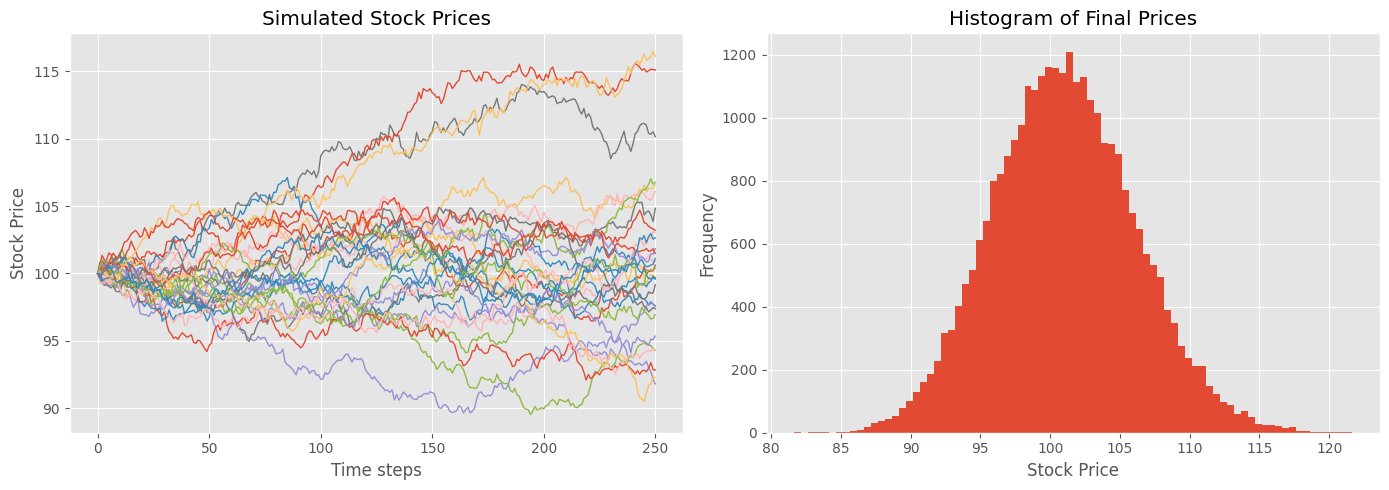

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

if isinstance(paths, torch.Tensor):
    for i in tqdm(range(n_simulations)):
        if i % 1000 == 0: # Just display a sub-set of the paths for illustration.
            axs[0].plot(paths[i].detach().numpy(), lw=1)

    axs[0].set_title("Simulated Stock Prices")
    axs[0].set_xlabel("Time steps")
    axs[0].set_ylabel("Stock Price")

axs[1].hist(final_prices.detach().numpy(), bins=80)
axs[1].set_title("Histogram of Final Prices")
axs[1].set_xlabel("Stock Price")
axs[1].set_ylabel("Frequency")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [15]:

payoffs = torch.max(final_prices - K, torch.zeros(n_simulations))
value = torch.mean(payoffs) * torch.exp(-r * T)
value.backward(retain_graph=True)

##### Verify
Check that the Monte Carlo output is a resonable approximation to the analytic

In [16]:
print("Monte Carlo results:")
mc_price = value.item()
mc_delta =  S.grad

print(f"Price {mc_price}")
print(f"delta: {mc_delta}")
print(f"vega: {sigma.grad}")
print(f"theta: {T.grad}")
print(f"rhos: {r.grad}")


Monte Carlo results:
Price 2.5419998168945312
delta: 0.587867259979248
vega: 39.34876251220703
theta: 1.54616117477417
rhos: 56.2446174621582


### Reuse the simulations to price an Asian option

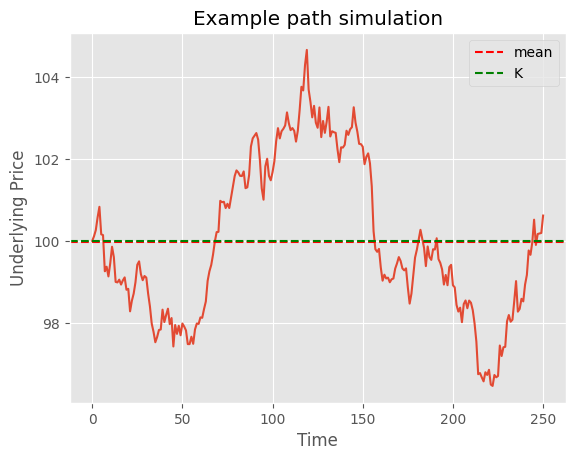

In [17]:
plt.plot(paths[0].detach().numpy())
plt.xlabel("Time")
plt.ylabel("Underlying Price")
plt.title("Example path simulation")
plt.axhline(y=torch.mean(paths[0]).detach().numpy(), color="r", linestyle="--", label="mean")
plt.axhline(y=100, color='g', linestyle="--", label="K")
plt.legend()

In [18]:
# Define the payoffs and return greeks.
payoffs = torch.max(torch.mean(final_prices) - K, torch.zeros(n_simulations))
value = torch.mean(payoffs) * torch.exp(-r * T)
value.backward()

In [19]:
print(f"Price:{value.item()}")
print(f"Delta: {S.grad}\nVega: {sigma.grad}\nTheta: {T.grad}\nRho: {r.grad}")

Price:0.9946725964546204
Delta: 1.5878634452819824
Vega: 39.37916946411133
Theta: 2.536972999572754
Rho: 155.24974060058594


### Notes:

a. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1626547 see re: use of HeavisideApprox
